# Import and pyspark setup

In [ ]:
from google.colab import drive
import os
!pip install -q findspark
import findspark
import datetime
import pandas as pd
import seaborn as sns #sb
import matplotlib.pyplot as plt #mp
import time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive
!tar xf /content/drive/MyDrive/spark-3.0.3-bin-hadoop2.7.tgz

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [ ]:
findspark.init()
findspark.find()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Data Read

Schema for OnReporting csv file

In [ ]:
fire_schema = StructType([StructField('MONTH', IntegerType(), True),
                    StructField('DAY_OF_MONTH', IntegerType(), True),
                    StructField('DAY_OF_WEEK', IntegerType(), True),
                    StructField('OP_UNIQUE_CARRIER', StringType(), True),
                    StructField('TAIL_NUM', StringType(), True),
                    StructField('OP_CARRIER_FL_NUM', StringType(), True),
                    StructField('ORIGIN_AIRPORT_ID', StringType(), True),
                    StructField('ORIGIN', StringType(), True),
                    StructField('ORIGIN_CITY_NAME', StringType(), True),
                    StructField('DEST_AIRPORT_ID', StringType(), True),
                    StructField('DEST', StringType(), True),
                    StructField('DEST_CITY_NAME', StringType(), True),
                    StructField('CRS_DEP_TIME', FloatType(), True),
                    StructField('DEP_TIME', FloatType(), True),
                    StructField('DEP_DELAY_NEW', FloatType(), True),
                    StructField('DEP_DEL15', FloatType(), True),
                    StructField('DEP_TIME_BLK', FloatType(), True),
                    StructField('CRS_ARR_TIME', FloatType(), True),
                    StructField('ARR_TIME', FloatType(), True),
                    StructField('ARR_DELAY_NEW', FloatType(), True),
                    StructField('ARR_TIME_BLK', FloatType(), True),
                    StructField('CANCELLED', FloatType(), True),
                    StructField('CANCELLATION_CODE', StringType(), True),
                    StructField('CRS_ELAPSED_TIME', FloatType(), True),
                    StructField('ACTUAL_ELAPSED_TIME', FloatType(), True),
                    StructField('DISTANCE', FloatType(), True),
                    StructField('DISTANCE_GROUP', StringType(), True),
                    StructField('CARRIER_DELAY', FloatType(), True),
                    StructField('WEATHER_DELAY', FloatType(), True),
                    StructField('NAS_DELAY', FloatType(), True),
                    StructField('SECURITY_DELAY', FloatType(), True),
                    StructField('LATE_AIRCRAFT_DELAY', FloatType(), True),
                    StructField('_c32', StringType(), True),
                          ])

Path for loading data into HDFS

In [ ]:
basepath = "/content/drive/MyDrive/Data_Engineering/Data/"
onTimeReportingFile = basepath + "ONTIME_REPORTING_01.csv"
carrierDecodeFile = basepath + 'CARRIER_DECODE.csv'
airportWeatherFile = basepath+"airport_weather_2020.csv"
aircraftInventoryFile = basepath + "B43_AIRCRAFT_INVENTORY.csv"
airportListFile = basepath + "airports_list.csv"
airportWeather2019File = basepath + "airport_weather_2019.csv"
onTimeReportingBaseFile = "ONTIME_REPORTING_"

Load raw data into ec2 instance

In [ ]:
!ln -s "/content/drive/My Drive/pratyush_remote_exec.sh" "/content/pratyush_remote_exec.sh"
!ln -s "/content/drive/My Drive/copyToColab.sh" "/content/copyToColab.sh"
!ln -s "/content/drive/My Drive/copyFromColab.sh" "/content/copyFromColab.sh"
!ln -s "/content/drive/My Drive/DA231o.pem" "/content/DA231o.pem"

In [ ]:
!chmod u+x ./pratyush_remote_exec.sh
!chmod u+x ./copyToColab.sh
!chmod u+x ./copyFromColab.sh
!chmod 400 ./DA231o.pem

In [ ]:
onTimeReportingFile = basepath + "ONTIME_REPORTING_12.csv" #example for loading one file
!./copyFromColab.sh $airportWeather2019File rawdata

Load rawdata from ec2 instance to HDFS

In [ ]:
!./pratyush_remote_exec.sh "hdfs dfs -put /home/ubuntu/rawdata/* HDFS_RAWDATA"

ssh -t -o StrictHostKeyChecking=no -i DA231o.pem ubuntu@ec2-15-206-79-163.ap-south-1.compute.amazonaws.com /usr/local/hadoop/bin/hdfs dfs -put /home/ubuntu/rawdata/* HDFS_RAWDATA
Connection to ec2-15-206-79-163.ap-south-1.compute.amazonaws.com closed.


Fetching data from HDFS to ec2

In [ ]:
!./pratyush_remote_exec.sh "hdfs dfs -copyToLocal HDFS_RAWDATA/* /home/ubuntu/rawdata_outbound"

ssh -t -o StrictHostKeyChecking=no -i DA231o.pem ubuntu@ec2-15-206-79-163.ap-south-1.compute.amazonaws.com /usr/local/hadoop/bin/hdfs dfs -copyToLocal HDFS_RAWDATA/* /home/ubuntu/rawdata_outbound
Connection to ec2-15-206-79-163.ap-south-1.compute.amazonaws.com closed.


Load data into colab

In [ ]:
!mkdir rawDataFromHDFS
!mkdir CleanedData
!mkdir Results

In [ ]:
!./copyToColab.sh rawdata_outbound/* rawDataFromHDFS

Read csv files and create Data frame

In [ ]:
basepath = "/content/rawDataFromHDFS/"
onTimeReportingFile = basepath + "ONTIME_REPORTING_01.csv"
carrierDecodeFile = basepath + 'CARRIER_DECODE.csv'
airportWeatherFile = basepath+"airport_weather_2020.csv"
aircraftInventoryFile = basepath + "B43_AIRCRAFT_INVENTORY.csv"
airportListFile = basepath + "airports_list.csv"
airportWeather2019File = basepath + "airport_weather_2019.csv"
onTimeReportingBaseFile = "ONTIME_REPORTING_"

In [ ]:
carrierDecodeDF = spark.read.option("header", True).option("delimiter", ",").csv(carrierDecodeFile)
ap_weatherDF = spark.read.option("header", True).csv(airportWeatherFile)
airportListDF = spark.read.option("delimiter", ",").csv(airportListFile, header = True)
aircraftInventoryDF = spark.read.option("delimiter", ",").csv(aircraftInventoryFile, header = True)
airportWeather2019DF = spark.read.option("delimiter", ",").csv(airportWeather2019File, header = True)

In [ ]:
def dropNullColumnsFromOnTimeReporting(AirCraftIP):
  print("Number of records before: ",AirCraftIP.count())
  sc_fil=AirCraftIP.filter(AirCraftIP.CARRIER_DELAY.isNotNull())
  sc_fil2=sc_fil.filter(sc_fil.WEATHER_DELAY.isNotNull())
  sc_fil3=sc_fil2.filter(sc_fil2.NAS_DELAY.isNotNull())
  sc_fil4=sc_fil3.filter(sc_fil3.SECURITY_DELAY.isNotNull())
  sc_fil5=sc_fil4.filter(sc_fil4.LATE_AIRCRAFT_DELAY.isNotNull())
  print("Number of records after filter: ",sc_fil5.count())
  return sc_fil5

def fillNAWithZeros(df, subsetColumns):
  return df.na.fill( value=0, subset=subsetColumns )

def preProcessOnTimeReportingDF(dataDF):
  tempDF = dataDF.select("MONTH", "DAY_OF_MONTH","DAY_OF_WEEK","OP_UNIQUE_CARRIER","OP_CARRIER_FL_NUM","TAIL_NUM","CANCELLATION_CODE","ORIGIN_AIRPORT_ID", "DEP_DELAY_NEW","DEP_TIME", "DEP_TIME_BLK", "ARR_DELAY_NEW", "ARR_TIME_BLK", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "DEP_DEL15", "ARR_TIME","CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME","CANCELLED","ORIGIN_CITY_NAME", "DEST_CITY_NAME")
  # filter not null records - weather_delay, carrier_delay, nas_delay, security_delay, late_aircraft_delay
  tempDF = fillNAWithZeros(tempDF, ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] )
  # create custom columns date_of_journey, Target, Depblock
  tempDF = tempDF.withColumn("DATE_OF_JOURNEY", concat(col("MONTH"), lit('/'), col("DAY_OF_MONTH"), lit('/'), lit('2019')))
  tempDF = tempDF.withColumn('Target',  (tempDF.CARRIER_DELAY + tempDF.WEATHER_DELAY + tempDF.NAS_DELAY + tempDF.SECURITY_DELAY + tempDF.LATE_AIRCRAFT_DELAY))
  tempDF = tempDF.withColumn("Depblock", (expr("(floor(DEP_TIME/100))%24")))
  # distinct
  tempDF = tempDF.distinct()
  return tempDF

def preProcessWeatherDF(airportWeather2019DF):
  airportWeather2019CleanedDF = airportWeather2019DF.select("NAME", "DATE", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN").withColumnRenamed("NAME", "AIRPORT_NAME")
  airportWeather2019CleanedDF = airportWeather2019CleanedDF.withColumn("DATE_NAME", concat(col("DATE"), lit('_'), col("AIRPORT_NAME")))
  airportWeather2019CleanedDF = airportWeather2019CleanedDF.select("DATE_NAME", "DATE", "AIRPORT_NAME", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN")
  return airportWeather2019CleanedDF

In [ ]:
def createFinalDataset(monthsList):
  initialReportingFile = spark.read.option("delimiter", ",").csv(onTimeReportingFile, header=True, schema=fire_schema)
  initialReportingFile = preProcessOnTimeReportingDF(initialReportingFile)

  for month in monthsList:
    ontimeReportingFile = basepath + onTimeReportingBaseFile + month + ".csv"
    ontimeReportingDF = spark.read.option("delimiter", ",").csv(ontimeReportingFile, header = True,schema=fire_schema)
    ontimeReportingpreProcessedDF = preProcessOnTimeReportingDF(ontimeReportingDF)
    initialReportingFile = ontimeReportingpreProcessedDF.union(initialReportingFile)

  print("Number of records in initialReportingFile : ",initialReportingFile.count())

  reportingCleanedDF = initialReportingFile
  carrierCleanedDecodeDF = carrierDecodeDF.select("AIRLINE_ID", "OP_UNIQUE_CARRIER","CARRIER_NAME").distinct().dropDuplicates(['OP_UNIQUE_CARRIER'])
  airportListCleanedDF = airportListDF.select("ORIGIN_AIRPORT_ID", "NAME").distinct().withColumnRenamed("ORIGIN_AIRPORT_ID", "SOURCE_AIRPORT_ID")
  aircraftInventoryCleanedDF = aircraftInventoryDF.select("TAIL_NUM", "NUMBER_OF_SEATS").distinct()
  airportWeather2019CleanedDF = preProcessWeatherDF(airportWeather2019DF)

  #Save cleaned data
  carrierCleanedDecodeDF.toPandas().to_csv('CleanedData/carrierCleanedDecode.csv',index=False)
  reportingCleanedDF.toPandas().to_csv('CleanedData/reportingCleaned.csv',index=False)
  airportListCleanedDF.toPandas().to_csv('CleanedData/airportListCleaned.csv',index=False)
  aircraftInventoryCleanedDF.toPandas().to_csv('CleanedData/aircraftInventoryCleaned.csv',index=False)
  airportWeather2019CleanedDF.toPandas().to_csv('CleanedData/airportWeather2019Cleaned.csv',index=False)

  return reportingCleanedDF, carrierCleanedDecodeDF, airportListCleanedDF, aircraftInventoryCleanedDF, airportWeather2019CleanedDF

# Data Analysis

In [ ]:
def rankCarrierbasedOnAvgDelays(df, carrierDecodeDF, fromdate, todate):
  joinedDF = df.join(carrierDecodeDF, carrierDecodeDF.OP_UNIQUE_CARRIER==df.OP_UNIQUE_CARRIER, 'inner')
  joinedDF.createOrReplaceTempView("question1Table")
  whereClause = 'select * from question1Table where MONTH <= ' + str(todate.month)+ ' and MONTH >= '+str(fromdate.month)+' and DAY_OF_MONTH <= '+str(todate.day)+' and DAY_OF_MONTH >= '+ str(fromdate.day)
  step1df = spark.sql(whereClause)
  step1df.createOrReplaceTempView("step11Table")

  sumDF = spark.sql('''select CARRIER_NAME, count(*) as count, sum(CARRIER_DELAY) as carrSum,sum(WEATHER_DELAY) as weatherSum, sum(NAS_DELAY) as NASSum, sum(SECURITY_DELAY) as secSum, sum(LATE_AIRCRAFT_DELAY) as lateSum from step11Table group by CARRIER_NAME''')
  new_df = sumDF.withColumn('AverageDelay',  (sumDF.carrSum + sumDF.weatherSum + sumDF.NASSum + sumDF.secSum + sumDF.lateSum)/ 5)
  new_df.createOrReplaceTempView("sumDataView")
  resultLeast = spark.sql("Select CARRIER_NAME from sumDataView order by AverageDelay limit 5").rdd.map(lambda x : x[0]).collect()
  resultMost = spark.sql("Select CARRIER_NAME from sumDataView order by AverageDelay desc limit 5").rdd.map(lambda x : x[0]).collect()
  return resultLeast,resultMost

fromdate = datetime.datetime.strptime('01/01/2011', '%d/%m/%Y')
todate = datetime.datetime.strptime('05/01/2011', '%d/%m/%Y')



In [ ]:
#Correlation Matrix of Data
def visualizeCorrelationMatrix(df):
  # create target column
  new_df = df.withColumn('Target',when(df.Target >0 ,1).otherwise(0))

  # drop unwanted columns
  columns_to_drop = ['CARRIER_DELAY', 'WEATHER_DELAY','NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY','TAIL_NUM','DATE_OF_JOURNEY']
  new_df = new_df.drop(*columns_to_drop)

  # fill na with 0, unknown
  new_df = new_df.na.fill({"CANCELLATION_CODE": "unknown"})
  subsetColumns = ['DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']

  new_df = new_df.na.fill( value=0, subset=subsetColumns )

  # label encoding
  categoricalColumns = 'OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'CANCELLATION_CODE', 'MONTH',"ORIGIN_CITY_NAME", "DEST_CITY_NAME"

  tempDF = new_df
  for i in categoricalColumns:
    indexer = StringIndexer(inputCol=i, outputCol=i+'_INDEXED')
    indexed = indexer.fit(tempDF).transform(tempDF)
    indexed = indexed.drop(i).withColumnRenamed(i+'_INDEXED',i)
    tempDF = indexed.withColumn(i,col(i).cast(IntegerType()))

  tempDF = tempDF.na.drop()
  # convert to vector column first
  vector_col = "corr_features"
  assembler = VectorAssembler(inputCols=tempDF.columns, outputCol=vector_col,handleInvalid="skip")
  df_vector = assembler.setHandleInvalid("skip").transform(tempDF).select(vector_col)

  # get correlation matrix
  matrix = Correlation.corr(df_vector, vector_col)
  result = matrix.collect()[0]["pearson({})".format(vector_col)].values
  corr_columns = tempDF.columns
  finalpdDF = pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)
  #To store data
  finalpdDF.to_csv('Results/finalpdDF.csv',index=False)

  return finalpdDF

In [ ]:
#Delay ranking based on SRC and DST
def SRC_DST_Delay(df):
  dfsrc = df.filter(df.DEP_DELAY_NEW>0)
  srcResult = (dfsrc
      .groupBy("ORIGIN_CITY_NAME")
      .count()
      .orderBy("count", ascending=False).take(30)
      )
  dfdst = df.filter(df.ARR_DELAY_NEW>0)
  dstResult = (dfdst
      .groupBy("DEST_CITY_NAME")
      .count()
      .orderBy("count", ascending=False).take(30)
  )
  return srcResult, dstResult

In [ ]:
#Delay ranking based on day of a week and time block
def Delay_Based_On_Time(df):

  dep_block_fil = df.filter(df.Depblock.isNotNull())
  delay_carrier = df.filter(df.CARRIER_DELAY>0)

  delayCarrierBlockwise = (delay_carrier
        .groupBy("Depblock")
        .count()
        .orderBy("Depblock", ascending=True)
        .take(30)
  )
  delayCarrierWeekwise = (delay_carrier
        .groupBy("DAY_OF_WEEK")
        .count()
        .orderBy("count", ascending=False)
        .take(30)
  )
  return delayCarrierBlockwise, delayCarrierWeekwise

In [ ]:
#Month wise delay count
def Month_Wise_Delay(customizedReportingDF,customizedaircraftInventoryDF):
  cancelledFlightsJoinedWithSeats = customizedReportingDF.join(customizedaircraftInventoryDF, customizedReportingDF.TAIL_NUM == customizedaircraftInventoryDF.TAIL_NUM)
  passengersAffectedByCancelledFlightsByMonth = cancelledFlightsJoinedWithSeats.select("MONTH", "NUMBER_OF_SEATS").groupBy("MONTH").count().orderBy("count", ascending = False)
  #To store data
  passengersAffectedByCancelledFlightsByMonthPd=passengersAffectedByCancelledFlightsByMonth.toPandas()
  passengersAffectedByCancelledFlightsByMonthPd.to_csv('Results/passengersAffectedByCancelledFlightsByMonth.csv',index=False)
  return passengersAffectedByCancelledFlightsByMonth

In [ ]:
#Comparison between weather delays and others
def Delay_based_on_weather(customizedReportingWithDateDF,customizedAirportListDF,airportWeather2019DF):
  ontimeReportingSummaryDF = customizedReportingWithDateDF.join(customizedAirportListDF, customizedReportingWithDateDF.ORIGIN_AIRPORT_ID == customizedAirportListDF.SOURCE_AIRPORT_ID)
  onTimeReportingSummaryWithNameDF = ontimeReportingSummaryDF.withColumn("DATE_NAME", concat(col("DATE_OF_JOURNEY"), lit('_'), col("NAME")))
  onTimeReportingSummaryFinalDF = onTimeReportingSummaryWithNameDF.select("DATE_NAME", "DATE_OF_JOURNEY", "NAME", "ORIGIN_AIRPORT_ID", "DEP_DELAY_NEW", "DEP_TIME_BLK", "ARR_DELAY_NEW", "ARR_TIME_BLK", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY")

  fullSummaryDF = onTimeReportingSummaryFinalDF.join(airportWeather2019DF, onTimeReportingSummaryFinalDF.DATE_NAME == airportWeather2019DF.DATE_NAME)

  fullSummaryWeatherDelaysDF = fullSummaryDF.select("DATE_OF_JOURNEY", "ORIGIN_AIRPORT_ID", "AIRPORT_NAME", "DEP_DELAY_NEW", "DEP_TIME_BLK", "ARR_DELAY_NEW", "ARR_TIME_BLK", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY").where("WEATHER_DELAY != '0.00'")#.show(10)
  fullSummaryOtherDelaysDF = fullSummaryDF.select("DATE_OF_JOURNEY", "ORIGIN_AIRPORT_ID", "AIRPORT_NAME", "DEP_DELAY_NEW", "DEP_TIME_BLK", "ARR_DELAY_NEW", "ARR_TIME_BLK", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY").where("WEATHER_DELAY == '0.00'")#.show(10)


  fullSummaryWeatherDelayCountsDF = fullSummaryWeatherDelaysDF.groupBy("AIRPORT_NAME").count().withColumnRenamed("count", "WEATHER_DELAYS")
  fullSummaryOtherDelayCountsDF = fullSummaryOtherDelaysDF.groupBy("AIRPORT_NAME").count().withColumnRenamed("count", "OTHER_DELAYS").withColumnRenamed("AIRPORT_NAME", "NAME")

  finalDelaysDF = fullSummaryWeatherDelayCountsDF.join(fullSummaryOtherDelayCountsDF, fullSummaryWeatherDelayCountsDF.AIRPORT_NAME == fullSummaryOtherDelayCountsDF.NAME).select("AIRPORT_NAME", "WEATHER_DELAYS", "OTHER_DELAYS")#.show(10)
  dfToPandas = finalDelaysDF.toPandas()
  #To store data
  dfToPandas.to_csv('Results/Delay.csv',index=False)
  return dfToPandas

In [ ]:
#Total and Average delays at Airports
def rankAvgDelaysbasedOnOriginAirports(df, fromdate, todate):
  df.createOrReplaceTempView("Table1")
  whereClause = 'select * from Table1 where ARR_DELAY_NEW > 0.0 and MONTH <= ' + str(todate.month)+ ' and MONTH >= '+str(fromdate.month)+' and DAY_OF_MONTH <= '+str(todate.day)+' and DAY_OF_MONTH >= '+ str(fromdate.day)
  df1 = spark.sql(whereClause)
  df1.createOrReplaceTempView("Table2")
  sumDF = spark.sql('''select ORIGIN_CITY_NAME, count(*) as counts, sum(ARR_DELAY_NEW) as DELAY_SUM from Table2 group by ORIGIN_CITY_NAME''')
  new_df = sumDF.withColumn('DELAY_AVG',  sumDF.DELAY_SUM/sumDF.counts)
  new_df.createOrReplaceTempView("sumDataView")
  sumDelayDF = spark.sql("Select ORIGIN_CITY_NAME, DELAY_SUM from sumDataView").sort('DELAY_SUM', ascending=False).limit(10)
  avgDelayDF = spark.sql("Select ORIGIN_CITY_NAME, DELAY_AVG from sumDataView").sort('DELAY_AVG', ascending=False).limit(10)
  #To store data
  sumDelayDFPd=sumDelayDF.toPandas()
  avgDelayDFPd=avgDelayDF.toPandas()
  sumDelayDFPd.to_csv('Results/sumDelayDF.csv',index=False)
  avgDelayDFPd.to_csv('Results/avgDelayDF.csv',index=False)
  return avgDelayDF, sumDelayDF

In [ ]:
#Percentage of flights delayed
def percentageDelayVsOnTime(df, fromdate, todate):
  df.createOrReplaceTempView("Table1")
  whereClause = 'select * from Table1 where DEP_DELAY_NEW > 0.0 and MONTH <= ' + str(todate.month)+ ' and MONTH >= '+str(fromdate.month)+' and DAY_OF_MONTH <= '+str(todate.day)+' and DAY_OF_MONTH >= '+ str(fromdate.day)
  df1 = spark.sql(whereClause)
  df1.createOrReplaceTempView("Table2")
  delay = df1.count()/df.count()*100
  return spark.createDataFrame([("Delayed",delay),("OnTime",100-delay)], ["Category","Value"])

#Percentage of different delays among delayed flights
def delayPercentageEachCategory(df, fromdate, todate):
  df.createOrReplaceTempView("Table1")
  whereClause = 'select * from Table1 where MONTH <= ' + str(todate.month)+ ' and MONTH >= '+str(fromdate.month)+' and DAY_OF_MONTH <= '+str(todate.day)+' and DAY_OF_MONTH >= '+ str(fromdate.day)
  df1 = spark.sql(whereClause)
  df1.createOrReplaceTempView("Table2")
  sumDF = spark.sql('''select sum(CARRIER_DELAY) as carrSum,sum(WEATHER_DELAY) as weatherSum, sum(NAS_DELAY) as NASSum, sum(SECURITY_DELAY) as secSum, sum(LATE_AIRCRAFT_DELAY) as lateSum from Table2''')
  delays = sumDF.collect()[0]
  sums = (delays["carrSum"]+delays["weatherSum"]+delays["NASSum"]+delays["secSum"]+delays["lateSum"])/100
  return spark.createDataFrame([("CARRIER_DELAY",delays["carrSum"]/sums),("WEATHER_DELAY",delays["weatherSum"]/sums),("NAS_DELAY",delays["NASSum"]/sums),("SECURITY_DELAY",delays["secSum"]/sums),("LATE_AIRCRAFT_DELAY",delays["lateSum"]/sums)],["Category","Value"])

## Generate Report

In [ ]:
def plotBar(sparkRows,title, xlabel, ylabel):
  resultList = []
  for i in range(0,len(sparkRows)):
    row_d = sparkRows[i].asDict()
    resultList = resultList + [row_d]
  resultdf = pd.DataFrame.from_records(resultList)
  fig, ax = plt.subplots(figsize=(20, 5))
  sns.barplot(resultdf, x = xlabel, y = ylabel,  dodge = False,  saturation  = 0.75, width=0.5).set(title=title)
  plt.xticks(rotation=90)
  plt.show()
  print("\n")
  return

def getResults(reportingCleanedDF,carrierCleanedDecodeDF, fromdate, todate, aircraftInventoryCleanedDF, airportListCleanedDF,airportWeather2019CleanedDF ):

  # 1
  resultLeast,resultMost = rankCarrierbasedOnAvgDelays(reportingCleanedDF, carrierCleanedDecodeDF, fromdate, todate)
  print("Rank Airlines based on delays ",fromdate.strftime('%d,%b 2019'), " to ",todate.strftime('%d,%b 2019'))
  print("\nAscending order - ")
  print(*resultLeast, sep = "\n")
  print("\nDescending order - ")
  print(*resultMost, sep = "\n")

  # 2
  resultDF = visualizeCorrelationMatrix(reportingCleanedDF)
  dataplot = sns.heatmap(resultDF)
  plt.show()

  # 3
  srcResult , dstResult = SRC_DST_Delay(reportingCleanedDF)
  plotBar(srcResult,"Delay by Origin City","ORIGIN_CITY_NAME", "count")
  plotBar(dstResult,"Delay by Destination City","DEST_CITY_NAME", "count")

  # 4
  delayCarrierBlockwise, delayCarrierWeekwise = Delay_Based_On_Time(reportingCleanedDF)
  plotBar(delayCarrierBlockwise,"Delay by Block","Depblock", "count")
  plotBar(delayCarrierWeekwise,"Delay by Week","DAY_OF_WEEK", "count")

  # 5
  result = Month_Wise_Delay(reportingCleanedDF,aircraftInventoryCleanedDF)
  plt.title ("Monthwise distribution of passengers effected by cancellation of fights")
  sns.barplot(result.toPandas(), x = "MONTH", y = "count", hue = "count", dodge = False, palette = "hls", saturation  = 0.75)
  plt.show()
  print("\n")

  # 6
  result = Delay_based_on_weather(reportingCleanedDF,airportListCleanedDF,airportWeather2019CleanedDF)
  fig, ax = plt.subplots(figsize=(10, 5))
  plt.plot(result['AIRPORT_NAME'], result['WEATHER_DELAYS'], label = "WEATHER_DELAYS")
  plt.plot(result['AIRPORT_NAME'], result['OTHER_DELAYS'], label = "OTHER_DELAYS")
  plt.xticks(rotation = 90)
  plt.legend()
  plt.show()
  print("\n")

  # 7
  avgDF, sumDF = rankAvgDelaysbasedOnOriginAirports(reportingCleanedDF, fromdate, todate)
  sns.barplot(sumDF.toPandas(), x="ORIGIN_CITY_NAME", y="DELAY_SUM", hue="DELAY_SUM", dodge=False, palette='hls', saturation = 0.75).legend(title="Count", bbox_to_anchor=(1.05,1), loc="upper left")
  plt.title("Barplot of Total delay at Airtports")
  plt.xticks(rotation=90)
  plt.show()
  print(sumDF.show())
  sns.barplot(avgDF.toPandas(),x="ORIGIN_CITY_NAME", y="DELAY_AVG", hue="DELAY_AVG", dodge=False, palette='hls', saturation = 0.75).legend(title="Values", bbox_to_anchor=(1.05,1), loc="upper left")
  plt.title("Barplot of AverageDelay at Airports")
  plt.xticks(rotation=90)
  plt.show()
  print(avgDF.show())
  print("\n")

  # 8
  retDF = percentageDelayVsOnTime(reportingCleanedDF, fromdate, todate)
  valList = retDF.collect()
  plt.pie([row["Value"] for row in valList],labels=[row["Category"] for row in valList],autopct = "%f%%",startangle=140)
  plt.title("Pie chart - Pct. of flights delayed")
  plt.show()
  print(retDF.show())
  retDF = delayPercentageEachCategory(reportingCleanedDF, fromdate, todate)
  valList = retDF.collect()
  plt.pie([row["Value"] for row in valList],labels=[row["Category"] for row in valList],autopct = "%f%%",startangle=140)
  plt.title("Pie chart - pct. of different delays among delayed flights")
  plt.show()
  print(retDF.show())
  print("\n")

  return

def evaluateProject():
  fromdate = datetime.datetime.strptime('01/01/2011', '%d/%m/%Y')
  todate = datetime.datetime.strptime('05/01/2011', '%d/%m/%Y')
  monthsList = ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
  #monthsList = []
  #monthsList = ["02", "03", "04"]
  start_time = time.time()
  reportingCleanedDF, carrierCleanedDecodeDF, airportListCleanedDF, aircraftInventoryCleanedDF, airportWeather2019CleanedDF = createFinalDataset(monthsList)
  getResults(reportingCleanedDF,carrierCleanedDecodeDF, fromdate, todate, aircraftInventoryCleanedDF, airportListCleanedDF,airportWeather2019CleanedDF )
  print("\nExecution Time --- %s seconds ---" % (time.time() - start_time))

Number of records in initialReportingFile :  7422037
Rank Airlines based on delays  01,Jan 2019  to  05,Jan 2019

Ascending order - 
Hawaiian Airlines Inc.
Pinnacle Airlines Inc.
Spirit Air Lines
Allegiant Air
Frontier Airlines Inc.

Descending order - 
SkyWest Airlines Inc.
Southwest Airlines Co.
American Airlines Inc.
United Air Lines Inc.
JetBlue Airways


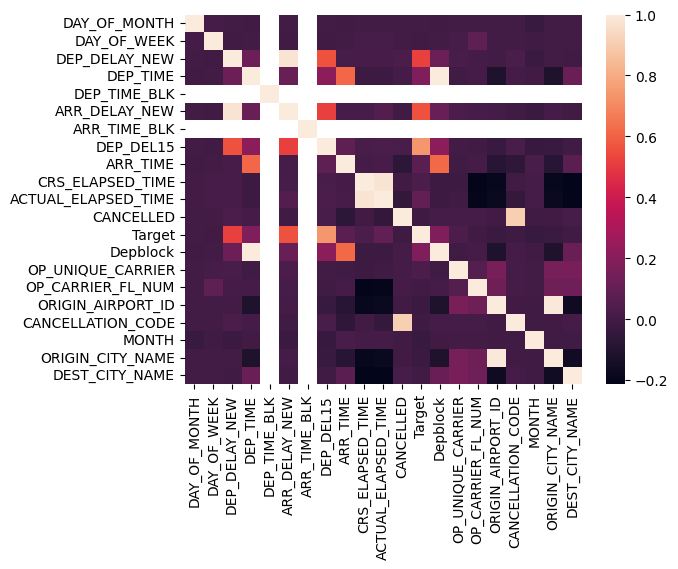

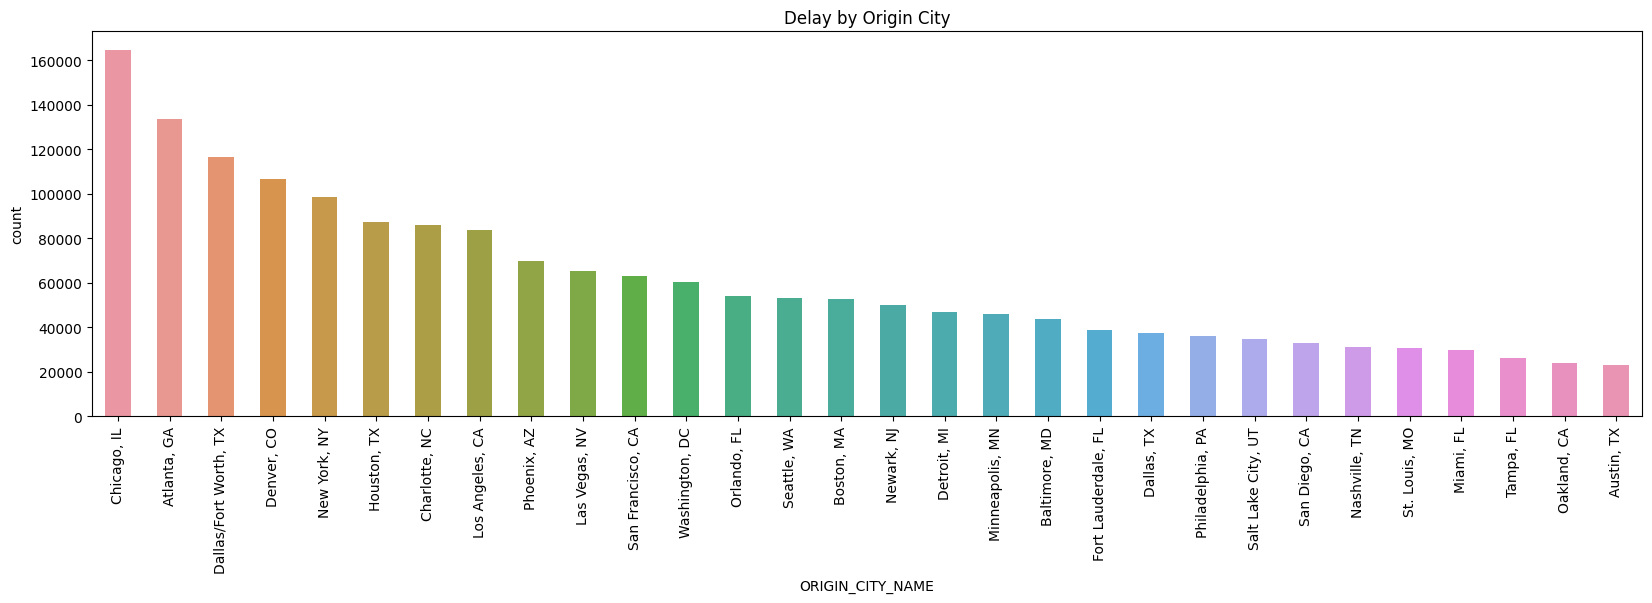

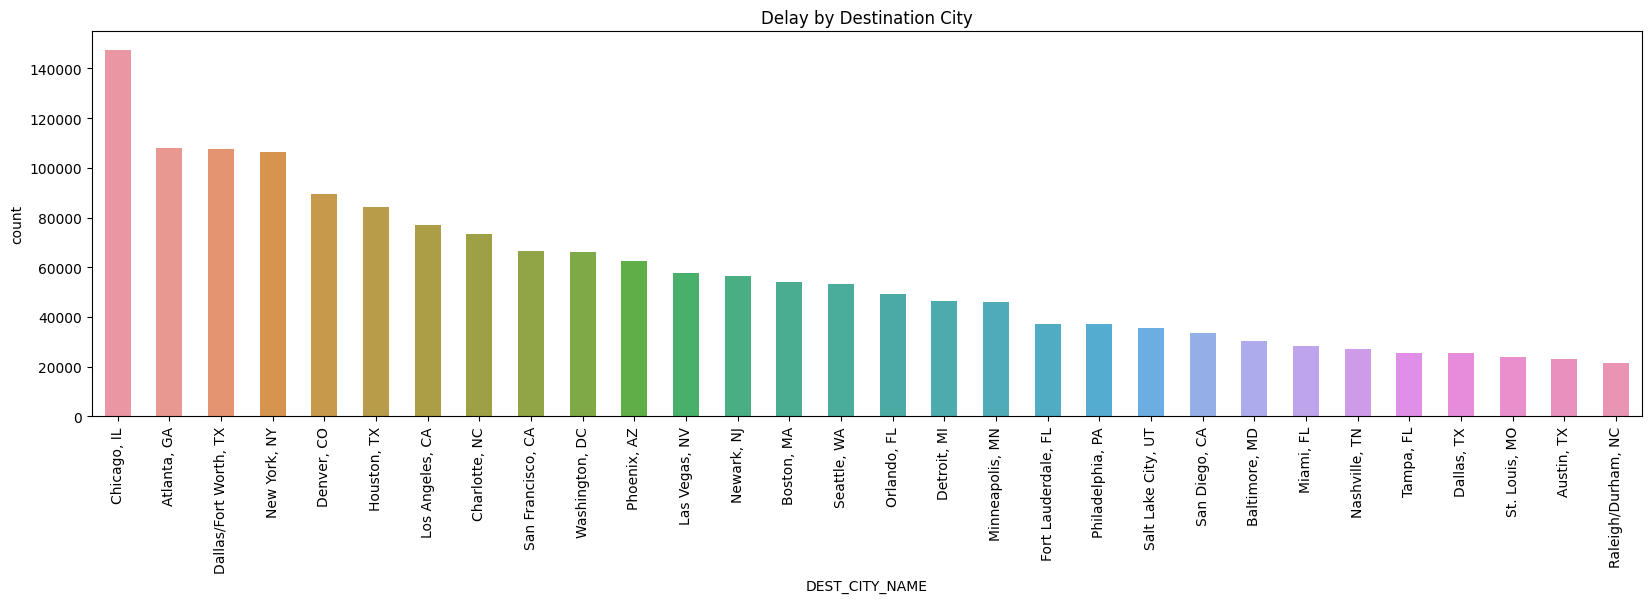

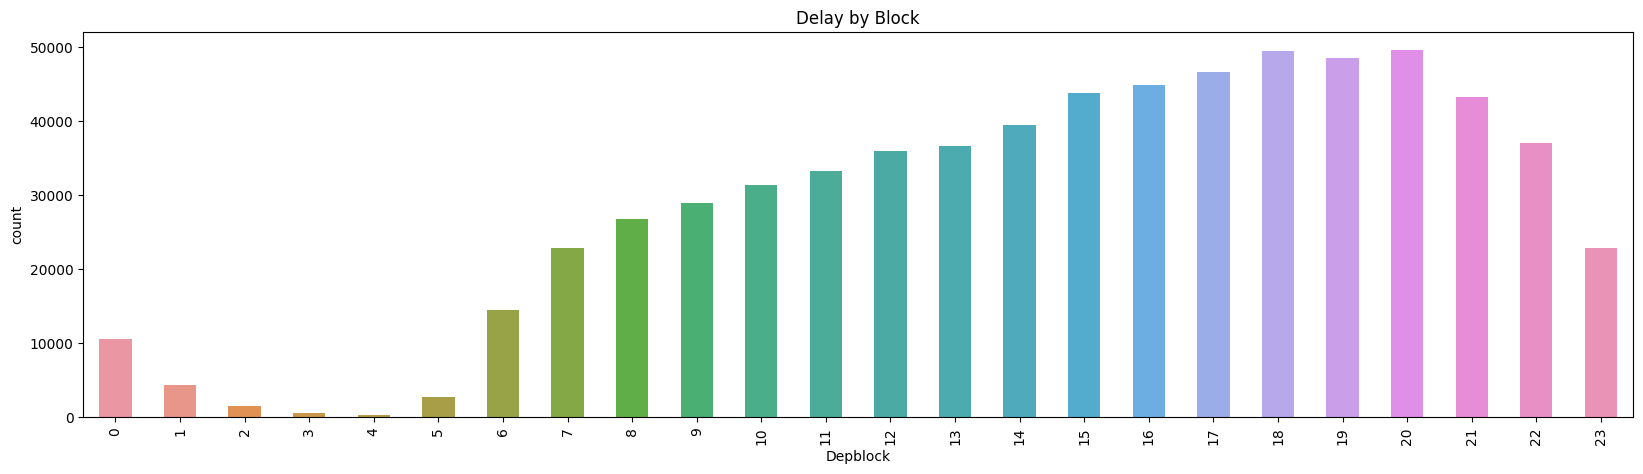

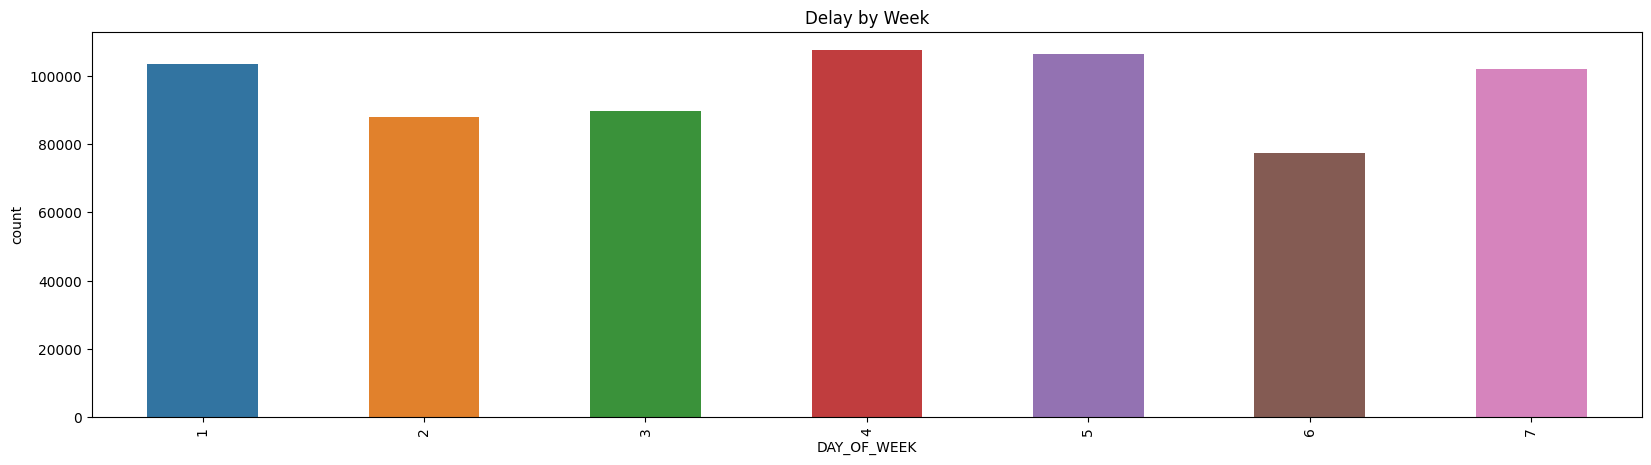

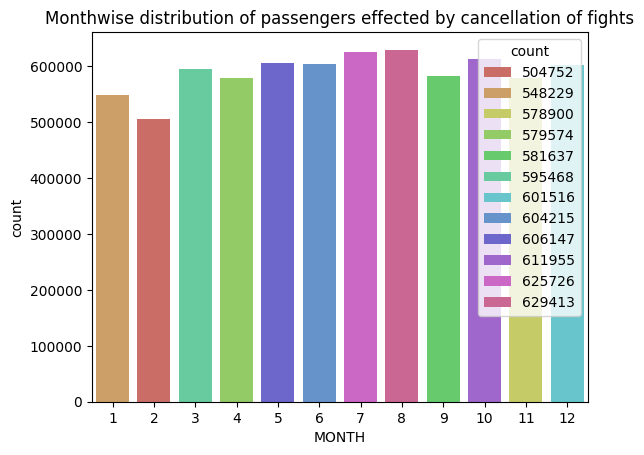

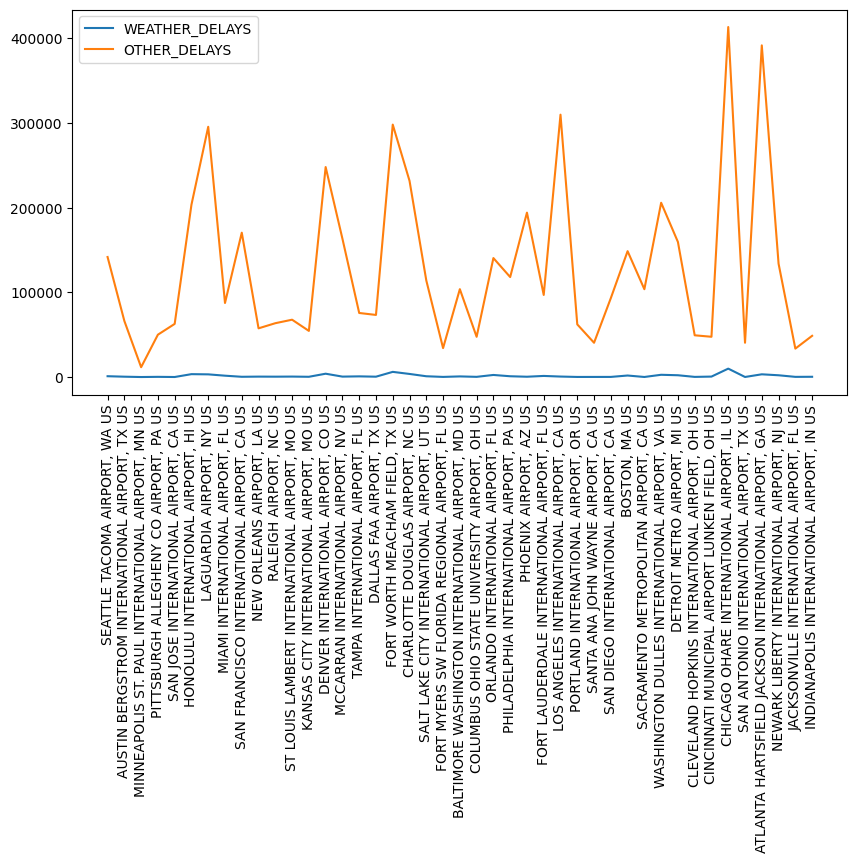

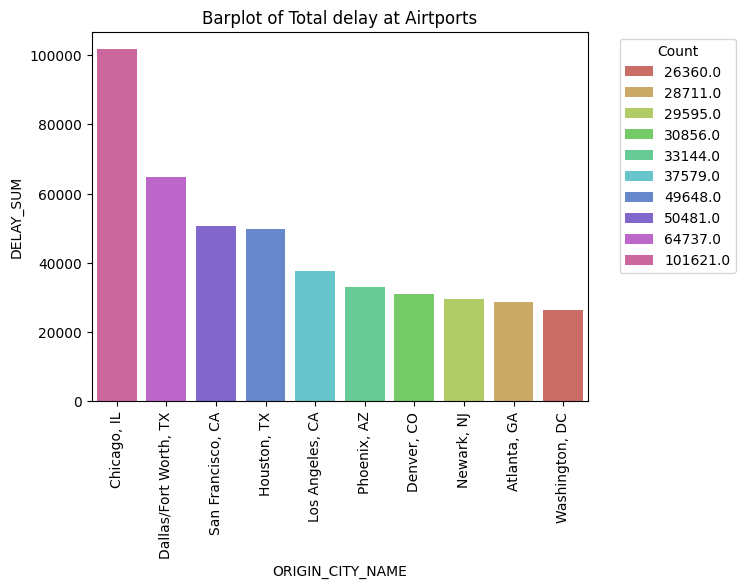

+--------------------+---------+
|    ORIGIN_CITY_NAME|DELAY_SUM|
+--------------------+---------+
|         Chicago, IL| 101621.0|
|Dallas/Fort Worth...|  64737.0|
|   San Francisco, CA|  50481.0|
|         Houston, TX|  49648.0|
|     Los Angeles, CA|  37579.0|
|         Phoenix, AZ|  33144.0|
|          Denver, CO|  30856.0|
|          Newark, NJ|  29595.0|
|         Atlanta, GA|  28711.0|
|      Washington, DC|  26360.0|
+--------------------+---------+

None


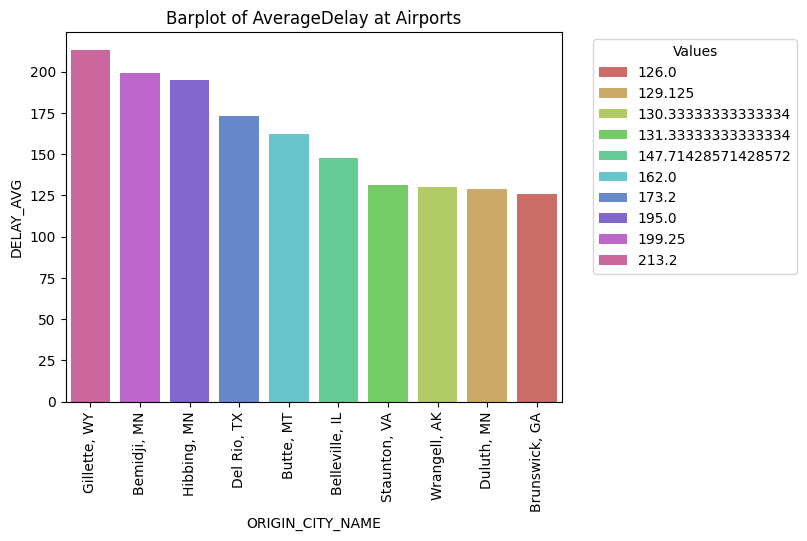

+----------------+------------------+
|ORIGIN_CITY_NAME|         DELAY_AVG|
+----------------+------------------+
|    Gillette, WY|             213.2|
|     Bemidji, MN|            199.25|
|     Hibbing, MN|             195.0|
|     Del Rio, TX|             173.2|
|       Butte, MT|             162.0|
|  Belleville, IL|147.71428571428572|
|    Staunton, VA|131.33333333333334|
|    Wrangell, AK|130.33333333333334|
|      Duluth, MN|           129.125|
|   Brunswick, GA|             126.0|
+----------------+------------------+

None




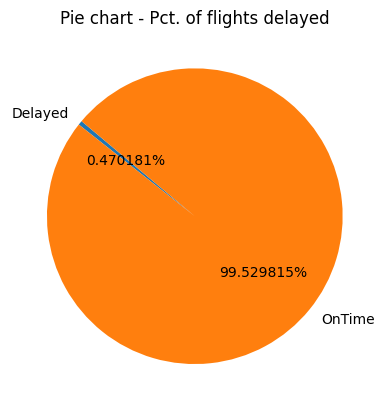

+--------+-------------------+
|Category|              Value|
+--------+-------------------+
| Delayed|0.47018089508311534|
|  OnTime|  99.52981910491688|
+--------+-------------------+

None


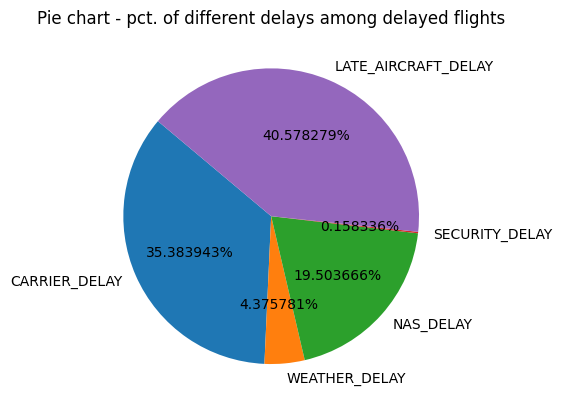

+-------------------+-------------------+
|           Category|              Value|
+-------------------+-------------------+
|      CARRIER_DELAY|  35.38394072487264|
|      WEATHER_DELAY|     4.375780401836|
|          NAS_DELAY| 19.503666857795384|
|     SECURITY_DELAY|0.15833607413853823|
|LATE_AIRCRAFT_DELAY|  40.57827594135744|
+-------------------+-------------------+

None



Execution Time --- 3612.539081096649 seconds ---


In [ ]:
evaluateProject()

# Save the cleaned data and reports to HDFS

In [ ]:
dstFile="/content/CleanedData/carrierCleanedDecode.csv"
!./copyFromColab.sh $dstFile cleanedData
dstFile="/content/CleanedData/reportingCleaned.csv"
!./copyFromColab.sh $dstFile cleanedData
dstFile="/content/CleanedData/airportListCleaned.csv"
!./copyFromColab.sh $dstFile cleanedData
dstFile="/content/CleanedData/aircraftInventoryCleaned.csv"
!./copyFromColab.sh $dstFile cleanedData
dstFile="/content/CleanedData/airportWeather2019Cleaned.csv"
!./copyFromColab.sh $dstFile cleanedData

In [ ]:
dstFile="/content/Results/Delay.csv"
!./copyFromColab.sh $dstFile processed_data
dstFile="/content/Results/avgDelayDF.csv"
!./copyFromColab.sh $dstFile processed_data
dstFile="/content/Results/passengersAffectedByCancelledFlightsByMonth.csv"
!./copyFromColab.sh $dstFile processed_data
dstFile="/content/Results/sumDelayDF.csv"
!./copyFromColab.sh $dstFile processed_data

In [ ]:
!./pratyush_remote_exec.sh "hdfs dfs -put /home/ubuntu/cleanedData/* HDFS_CLEANEDDATA"
!./pratyush_remote_exec.sh "hdfs dfs -put /home/ubuntu/processed_data/* HDFS_PROCESSEDDATA"

ssh -t -o StrictHostKeyChecking=no -i DA231o.pem ubuntu@ec2-15-206-79-163.ap-south-1.compute.amazonaws.com /usr/local/hadoop/bin/hdfs dfs -put /home/ubuntu/cleanedData/* HDFS_CLEANEDDATA
Connection to ec2-15-206-79-163.ap-south-1.compute.amazonaws.com closed.
ssh -t -o StrictHostKeyChecking=no -i DA231o.pem ubuntu@ec2-15-206-79-163.ap-south-1.compute.amazonaws.com /usr/local/hadoop/bin/hdfs dfs -put /home/ubuntu/processed_data/* HDFS_PROCESSEDDATA
put: `HDFS_PROCESSEDDATA/avgDelayDF.csv': File exists
put: `HDFS_PROCESSEDDATA/Delay.csv': File exists
put: `HDFS_PROCESSEDDATA/passengersAffectedByCancelledFlightsByMonth.csv': File exists
put: `HDFS_PROCESSEDDATA/sumDelayDF.csv': File exists
Connection to ec2-15-206-79-163.ap-south-1.compute.amazonaws.com closed.
